In [1]:
# imports necesarios
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# configuracion del dispositivo (gpu o cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# parametros geometricos del disipador
H_BASE = 10.0
L_SIZE = 50.0

# funcion que determina si un punto esta dentro del disipador
def is_inside_heatsink_np(x, y):
    in_base = y <= H_BASE
    f1 = (x >= 0.0) & (x <= 5.0)
    f2 = (x >= 15.0) & (x <= 20.0)
    f3 = (x >= 30.0) & (x <= 35.0)
    f4 = (x >= 45.0) & (x <= 50.0)
    
    in_fins = (y > H_BASE) & (y <= L_SIZE) & (f1 | f2 | f3 | f4)
    
    return (in_base | in_fins)


In [2]:
# definicion de la red neuronal con codificacion de fourier
class FourierPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.B = nn.Parameter(torch.randn(3, 20) * 2.0, requires_grad=False) 
        
        self.net = nn.Sequential(
            nn.Linear(40, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1) 
        )

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        x_fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return self.net(x_fourier)

# creacion del modelo y carga de pesos entrenados
model = FourierPINN().to(device)
model.load_state_dict(torch.load("heatsink_model_final.pth", map_location=device))
model.eval()


FourierPINN(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [3]:
# carga de parametros fisicos del problema
data = np.load("heatsink_data.npz")
params = data["params"]
L_SIZE_LOADED = params[1]
T_MAX_LOADED = params[2]
T_AMB = params[3]
T_BASE = params[4]
DELTA_T = T_BASE - T_AMB

if L_SIZE_LOADED != L_SIZE:
    L_SIZE = L_SIZE_LOADED


In [4]:
# creacion de la malla espacial
res = 200
x = np.linspace(0, L_SIZE, res)
y = np.linspace(0, L_SIZE, res)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()

# aplicacion de mascara geometrica
mask = is_inside_heatsink_np(X_flat, Y_flat)

frames = []

# parametros temporales para la animacion
N_FRAMES = 200
T_MAX_FOCUSED = 200.0

times_to_plot = np.linspace(0.0, T_MAX_FOCUSED, N_FRAMES) 

# generacion de frames con predicciones del modelo
with torch.no_grad():
    for t_val in times_to_plot:
        T_flat = np.full_like(X_flat, t_val)
        
        # preparacion de inputs
        inp_np = np.stack([X_flat, Y_flat, T_flat], axis=1)
        inp_tensor = torch.tensor(inp_np, dtype=torch.float32).to(device)
        
        # normalizacion de inputs
        inp_tensor[:, 0:2] /= L_SIZE
        inp_tensor[:, 2] /= T_MAX_LOADED 
        
        # prediccion del modelo
        pred_norm = model(inp_tensor).cpu().numpy().flatten()
        
        # desnormalizacion de temperatura
        pred_temp = pred_norm * DELTA_T + T_AMB
        
        # aplicacion de mascara
        pred_temp[~mask] = np.nan
        
        frames.append(pred_temp.reshape(res, res))


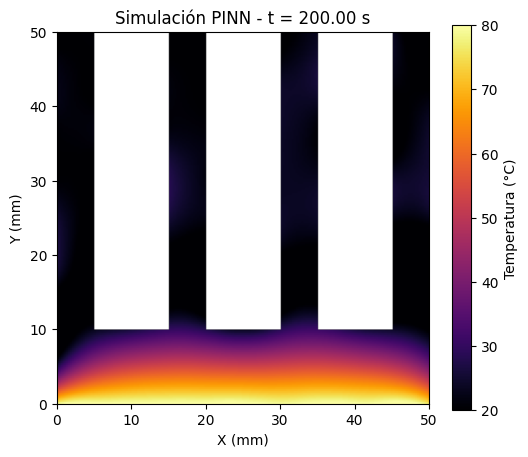

In [5]:
# configuracion de la figura y visualizacion
fig, ax = plt.subplots(figsize=(6, 5))

cax = ax.imshow(frames[0], extent=[0, L_SIZE, 0, L_SIZE], origin='lower', 
                cmap='inferno', vmin=T_AMB, vmax=T_BASE)
fig.colorbar(cax, label="Temperatura (°C)")
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_aspect('equal')
title = ax.set_title("Simulación PINN - t = 0.00 s")

# funcion de actualizacion de frames
def update(frame_idx):
    cax.set_array(frames[frame_idx])
    t_current = times_to_plot[frame_idx]
    title.set_text(f"Simulación PINN - t = {t_current:.2f} s")
    return cax, title

# creacion y guardado de la animacion
ani = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True) 

save_path = "simulacion_disipador_LINEAL_10s_FINAL.gif" 
ani.save(save_path, writer='pillow', fps=20) 
plt.show()
